# Crytocurrency price forecasting using Neural Networks

In [1]:
#! pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R_squared
from sklearn.metrics import explained_variance_score as EVS

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = 'D:/USMS/UChicago/STUDIES/Autumn 2020/MSCA 31009 2 Machine Learning & Predictive Analytics/Final Project/data/'

In [4]:
# importing the data
BTC_USD = pd.read_csv(data_path+'BTC-USD.csv')
BTC_USD.head()

Date        Open        High         Low       Close   Adj Close  \
0  23-11-15  324.350006  325.118011  321.290009  323.045990  323.045990   
1  24-11-15  323.014008  323.058014  318.118011  320.045990  320.045990   
2  25-11-15  320.045013  329.134003  316.769989  328.205994  328.205994   
3  26-11-15  328.303009  366.756989  328.229004  352.683990  352.683990   
4  27-11-15  351.860992  363.588989  347.869995  358.041992  358.041992   

      Volume  
0   27478900  
1   29362600  
2   41666900  
3  106105000  
4   55179100

In [5]:
# importing the data
XRP_USD = pd.read_csv(data_path+'XRP-USD.csv')
XRP_USD.head()

Date      Open      High       Low     Close  Adj Close  Volume
0  2015-11-23  0.004269  0.004351  0.004237  0.004288   0.004288  314451
1  2015-11-24  0.004288  0.004288  0.004201  0.004242   0.004242  197940
2  2015-11-25  0.004242  0.004325  0.004228  0.004318   0.004318  197356
3  2015-11-26  0.004317  0.004435  0.004227  0.004291   0.004291  400520
4  2015-11-27  0.004276  0.004304  0.004229  0.004276   0.004276  199790

In [6]:
# importing the data
ETH_USD = pd.read_csv(data_path+'ETH-USD.csv')
ETH_USD.head()

Date      Open      High       Low     Close  Adj Close  Volume
0  2015-11-26  0.863273  0.903643  0.804360  0.884183   0.884183  947473
1  2015-11-27  0.882100  0.900051  0.860695  0.867951   0.867951  403813
2  2015-11-28  0.868102  0.929293  0.862122  0.915703   0.915703  462464
3  2015-11-29  0.914144  0.914153  0.860533  0.878614   0.878614  448358
4  2015-11-30  0.879951  0.895054  0.847696  0.873119   0.873119  784439

Visualizing the data

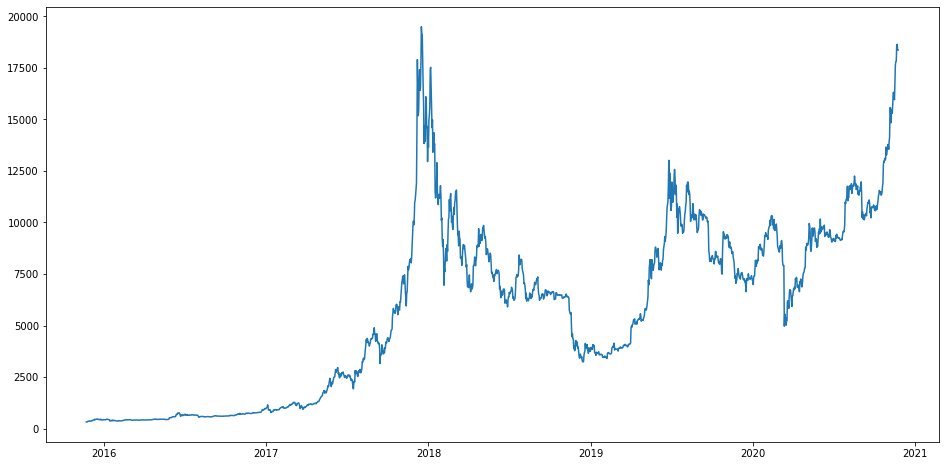

In [7]:
#setting index as date
BTC_USD['Date'] = pd.to_datetime(BTC_USD.Date,format='%d-%m-%y')
BTC_USD.index = BTC_USD['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(BTC_USD['Adj Close'], label='Close Price history')
plt.show()

Linear Regression is not designed to capture the short term dynamics or the autocorrelations which are present in this sequential data. It is more designed to look at the data globally and capture the global trend. We need a model that is able to capture the short term dynamics and short term dependencies within our dataset.

In the world of Neural Networks, we have something called **Recurrent Neural Networks** which is designed to capture these dependencies. Let's apply this and see how it performs in predicting the Bitcoin prices

In [8]:
BTC_USD.head()

Date        Open        High         Low       Close  \
Date                                                                    
2015-11-23 2015-11-23  324.350006  325.118011  321.290009  323.045990   
2015-11-24 2015-11-24  323.014008  323.058014  318.118011  320.045990   
2015-11-25 2015-11-25  320.045013  329.134003  316.769989  328.205994   
2015-11-26 2015-11-26  328.303009  366.756989  328.229004  352.683990   
2015-11-27 2015-11-27  351.860992  363.588989  347.869995  358.041992   

             Adj Close     Volume  
Date                               
2015-11-23  323.045990   27478900  
2015-11-24  320.045990   29362600  
2015-11-25  328.205994   41666900  
2015-11-26  352.683990  106105000  
2015-11-27  358.041992   55179100

In [9]:
BTC_USD.reset_index(drop=True,inplace=True)

In [10]:
BTC_USD.head()

Date        Open        High         Low       Close   Adj Close  \
0 2015-11-23  324.350006  325.118011  321.290009  323.045990  323.045990   
1 2015-11-24  323.014008  323.058014  318.118011  320.045990  320.045990   
2 2015-11-25  320.045013  329.134003  316.769989  328.205994  328.205994   
3 2015-11-26  328.303009  366.756989  328.229004  352.683990  352.683990   
4 2015-11-27  351.860992  363.588989  347.869995  358.041992  358.041992   

      Volume  
0   27478900  
1   29362600  
2   41666900  
3  106105000  
4   55179100

In [11]:
BTC_USD.shape

(1828, 7)

### Making the data ready for feeding to the RNNs

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# fix random seed for reproducibility
np.random.seed(5)

In [14]:
# take adjusted close price column
bitcoin_y = BTC_USD['Adj Close'].values
bitcoin_dataset=bitcoin_y.reshape(-1, 1)

In [15]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_dataset = scaler.fit_transform(bitcoin_dataset)

In [16]:
# split into train and test sets, 25% test data, 75% training data
bitcoin_train_size = int(len(bitcoin_dataset) * 0.75)
bitcoin_test_size = len(bitcoin_dataset) - bitcoin_train_size
bitcoin_train, bitcoin_test = bitcoin_dataset[0:bitcoin_train_size,:], bitcoin_dataset[bitcoin_train_size:len(bitcoin_dataset),:]

In [17]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
bitcoin_trainX, bitcoin_trainY = create_dataset(bitcoin_train, look_back)
bitcoin_testX, bitcoin_testY = create_dataset(bitcoin_test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
bitcoin_trainX = np.reshape(bitcoin_trainX, (bitcoin_trainX.shape[0], 1, bitcoin_trainX.shape[1]))
bitcoin_testX = np.reshape(bitcoin_testX, (bitcoin_testX.shape[0], 1, bitcoin_testX.shape[1]))

### Simple RNN

In [19]:
# using 10 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1105 - mean_squared_error: 0.11 - 0s 10ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.1247 - mean_squared_error: 0.12 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.1130 - mean_squared_error: 0.11 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0976 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.1182 - mean_squared_error: 0.11 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.1142 - mean_squared_error: 0.11 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/10
5/5 [==============================] - E

In [20]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [21]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We see that using 10 epochs resulted in not so good predictions as the model was not able to learn properly, it is underfitting. The accuracy is very low as well. Let's try with more epochs

In [22]:
# using 100 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0959 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0995 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1041 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.1080 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.1046 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0948 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.1057 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0984 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.1034 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.1034 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 58/100
5/5 [==============================] - E

In [23]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [24]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We now see that even after increasing the number of epochs, the performance of the simple RNN model did not improve. This shows that simple RNN was not able to capture the systematic patterns that we have in our data. Also, as in simple RNN, there is paramater sharing across the layers, there is **Vanishing Gradient Problem**. The neurons are not learning beyond a certain point as the weights have stopped updating due to this Vanishing Gradient Problem.

So, in order to solve this problem, we can use **LSTM (Long Short Term Memory)**

### LSTM - Long Short Term Memory

In [28]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.04 - ETA: 0s - loss: 0.0315 - mean_squared_error: 0.03 - 0s 15ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0061 - mean_squared_error: 

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [======================

In [29]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [30]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.03
Test RMSE for the bitcoin LSTM: 0.05


So, using LSTM we have seen **marked improvement** in the performance of the model and it is now making much **better predictions**.

In [31]:
# invert predictions
bitcoin_trainPredict_reverted = scaler.inverse_transform(bitcoin_trainPredict)
bitcoin_trainY_reverted = scaler.inverse_transform([bitcoin_trainY])
bitcoin_testPredict_reverted = scaler.inverse_transform(bitcoin_testPredict)
bitcoin_testY_reverted = scaler.inverse_transform([bitcoin_testY])

In [32]:
# shift train predictions for plotting
bitcoin_trainPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_trainPredictPlot[:, :] = np.nan
bitcoin_trainPredictPlot[look_back:len(bitcoin_trainPredict_reverted)+look_back, :] = bitcoin_trainPredict_reverted

In [33]:
# shift test predictions for plotting
bitcoin_testPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_testPredictPlot[:, :] = np.nan
bitcoin_testPredictPlot[len(bitcoin_trainPredict_reverted)+(look_back*2)+1:len(bitcoin_dataset)-1, :] = bitcoin_testPredict_reverted

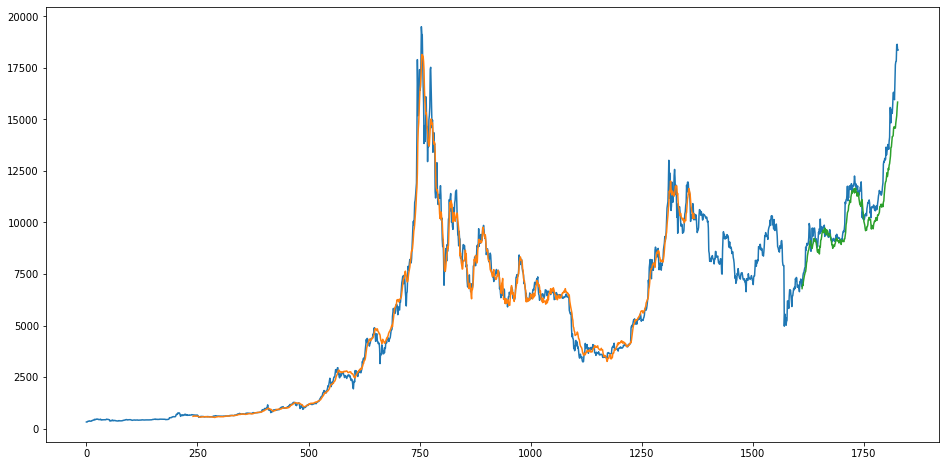

In [34]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(bitcoin_dataset))
plt.plot(bitcoin_trainPredictPlot)
plt.plot(bitcoin_testPredictPlot)

Now, let's try using a different optimizer - **Stochastic Gradient Descent** for LSTM

In [35]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1677 - mean_squared_error: 0.16 - 0s 6ms/step - loss: 0.1371 - mean_squared_error: 0.1371
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0967 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.0745 - mean_squared_error: 0.0745
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0542 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 7/10
5/5 [==============================] - ET

In [36]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [37]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.10
Test RMSE for the bitcoin LSTM: 0.15


We see **Stochastic Gradient Descent** is not that effective as **ADAM** when it comes to optimizing the cost function

Using a different optimizer - **AdaGrad**

In [38]:
# create and fit the LSTM network, optimizer=Adagrad, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='Adagrad',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.0866 - mean_squared_error: 0.08 - 0s 6ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0818 - mean_squared_error: 0.08 - 0s 6ms/step - loss: 0.0754 - mean_squared_error: 0.0754
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0647 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0667 - mean_squared_error: 0.0667
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0649 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0586 - mean_squared_error: 0.05 - 0s 9ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0551 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 7/10
5/5 [==============================] - ET

In [39]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [40]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.18
Test RMSE for the bitcoin LSTM: 0.27


**AdaGrad** also not performing that well, when compared to **ADAM**

### Hyperparameter tuning using Optuna

Now, let's try to tune our hyperparameters for the LSTM model to get the optimal parameters using **Optuna**

In [75]:
# defining the objective function
def objective(trial):
    units = trial.suggest_int('units', 2, 25)
    rate = trial.suggest_int('rate', 0.1, 0.9)
    #epochs = trial.suggest_int('epochs', 10, 100)
    bitcoin_lstm_model = Sequential()
    bitcoin_lstm_model.add(LSTM(units, input_shape=(1, look_back)))
    bitcoin_lstm_model.add(Dropout(rate))
    bitcoin_lstm_model.add(Dense(1))
    bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)
    # make predictions
    bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
    bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)
    
    bitcoin_trainScore = round(np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict)),2)
    bitcoin_testScore = round(np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict)),2)
    return bitcoin_testScore

Here, we have created the **study** object which contains all the information about the required parameter space.

In [78]:
# creating study object
study = optuna.create_study(direction='minimize')

# calling the optimize function
study.optimize(objective, n_trials=10)

[I 2020-11-28 17:47:11,330] A new study created in memory with name: no-name-c32697f5-487e-42a9-a2eb-d18ee18ea42b


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0648 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0421 - mean_squared_error: 0.0421
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0286 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:47:18,505] Trial 0 finished with value: 0.07 and parameters: {'units': 10, 'rate': 0}. Best is trial 0 with value: 0.07.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1305 - mean_squared_error: 0.13 - 0s 3ms/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0595 - mean_squared_error: 0.05 - 0s 3ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0250 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0233 - mean_squared_error: 0.0233
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0253 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:47:25,060] Trial 1 finished with value: 0.08 and parameters: {'units': 3, 'rate': 0}. Best is trial 0 with value: 0.07.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0600 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0351 - mean_squared_error: 0.0351
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0126 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 9.0550e-04 - mean_squared_error: 9.0550e- - 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013    
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 9.9938e-04 - mean_squared_error: 9.9938e- - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 58/100
5/5

5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 8.3167e-04 - mean_squared_error: 8.3167e-04


[I 2020-11-28 17:47:31,782] Trial 2 finished with value: 0.06 and parameters: {'units': 5, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1410 - mean_squared_error: 0.14 - 0s 3ms/step - loss: 0.1233 - mean_squared_error: 0.1233
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0870 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0511 - mean_squared_error: 0.0511
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0265 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0135 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:47:38,975] Trial 3 finished with value: 0.07 and parameters: {'units': 6, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0974 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.0452 - mean_squared_error: 0.0452
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0245 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0233 - mean_squared_error: 0.0233
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 9.8851e-04 - mean_squared_error: 9.8851e- - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 7.5812e-04 - mean_squared_error: 7.5812e- - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 58/100
5/5

Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 5.0512e-04 - mean_squared_error: 5.0512e- - 0s 5ms/step - loss: 7.4750e-04 - mean_squared_error: 7.4750e-04


[I 2020-11-28 17:47:46,243] Trial 4 finished with value: 0.06 and parameters: {'units': 20, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0645 - mean_squared_error: 0.06 - 0s 3ms/step - loss: 0.0521 - mean_squared_error: 0.0521
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0124 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:47:52,794] Trial 5 finished with value: 0.08 and parameters: {'units': 3, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1299 - mean_squared_error: 0.12 - 0s 4ms/step - loss: 0.0787 - mean_squared_error: 0.0787
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0293 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:47:59,397] Trial 6 finished with value: 0.07 and parameters: {'units': 9, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1526 - mean_squared_error: 0.15 - 0s 4ms/step - loss: 0.0756 - mean_squared_error: 0.0756
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0356 - mean_squared_error: 0.0356
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0318 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [==============================] - E

[I 2020-11-28 17:48:06,206] Trial 7 finished with value: 0.06 and parameters: {'units': 16, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0434 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 8.9978e-04 - mean_squared_error: 8.9978e- - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 7.2783e-04 - mean_squared_error: 7.2783e- - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 58/100
5/5 [===========

Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 8.2540e-04 - mean_squared_error: 8.2540e- - 0s 4ms/step - loss: 7.4551e-04 - mean_squared_error: 7.4551e-04


[I 2020-11-28 17:48:14,112] Trial 8 finished with value: 0.06 and parameters: {'units': 9, 'rate': 0}. Best is trial 2 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0613 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0252 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 9.6537e-04 - mean_squared_error: 9.6537e- - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 58/100
5/5 [==========

Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 6.9155e-04 - mean_squared_error: 6.9155e- - 0s 5ms/step - loss: 7.3961e-04 - mean_squared_error: 7.3961e-04


[I 2020-11-28 17:48:22,985] Trial 9 finished with value: 0.06 and parameters: {'units': 13, 'rate': 0}. Best is trial 2 with value: 0.06.


In [80]:
# best test error
trial = study.best_trial
print('Best test error: {}'.format(trial.value))

Best test error: 0.06


In [81]:
# best hyperparameters
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'units': 5, 'rate': 0}


So, we saw that using **Optuna**, we got the best hyperparameters of **number of LSTM units** and **number of dropout nodes** as **5** and **0** respectively. Similarly, we can use this to tune other hyperparameters as well.